<a href="https://colab.research.google.com/github/alelom/Notebooks/blob/master/Statistical%20Learning/Pytorch/Exercise%20Files/CPU_to_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU to GPU

In [3]:
import torch

# Specify CUDA device if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [5]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw




Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [8]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

## Copy the ANN model into the GPU.
This will move the model from CPU memory to GPU.
PyTorch will recursevily go over all the modules and convert their parameters and buffers to CUDA Tensor.

In [9]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

We also need to send the input images and the true labels (targets) to the GPU.

In [11]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device) # sends the input images to GPU
        labels = labels.to(device) # sends the true labels (targets) to GPU
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.00529362083371
Training loss: 0.5533570862972914
Training loss: 0.4860633622799347


## Testing
* When we are **training**, we want to be using **GPU**.  
* When **testing**, we should be using **CPU**.

This is because, in real-world, you most commonly will not have a GPU available on the device where you need to deploy.  
For example, an image recognition using a ANN may get deployed on a CCTV camera, which certainly doesn't have a GPU.

To do this, we need to copy the model again, this time from the GPU to the CPU.  
We don't need to copy over the input images again, because by default the `trainloader` is kept on CPU.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

model.to("cpu") # moves the model back to the CPU. 

with torch.no_grad():
    logps = model(img) # compute the output prediction with the model

In [16]:
ps = torch.exp(logps)
ps

tensor([[7.1154e-06, 1.2555e-06, 2.3612e-05, 3.4517e-06, 1.3482e-04, 1.6553e-01,
         1.9460e-05, 2.7981e-01, 7.4513e-03, 5.4702e-01]])

In [17]:
nps = ps.numpy()[0]
nps

array([7.1153900e-06, 1.2555362e-06, 2.3612120e-05, 3.4516893e-06,
       1.3482185e-04, 1.6553016e-01, 1.9460160e-05, 2.7981287e-01,
       7.4513098e-03, 5.4701591e-01], dtype=float32)

<BarContainer object of 10 artists>

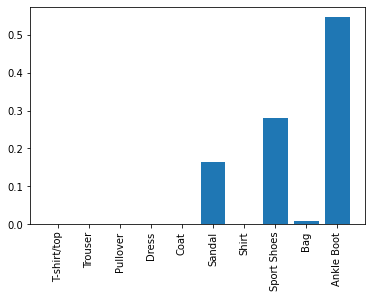

In [18]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

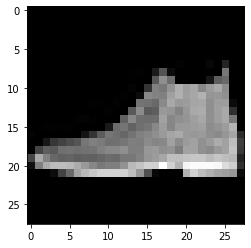

In [19]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')

Check what error you get if you keep the model on GPU and ask the 

In [21]:
model.to(device) # just for checking the error, move back the model to GPU

import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

with torch.no_grad():
    logps = model(img) # Throws error. You're asking to compute the output prediction with the model, which is currently on GPU, while the images and labels are still on CPU.

RuntimeError: ignored